In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
plt.rcParams['figure.figsize'] = (24, 16)
import math
import os

### Functions

In [2]:
def process_food_file(df):
    
    """
    This loads in each food file for each unique subject and processes it.
    
    First I will join date and time into one column.
    Since I don't plan on using computer vision I will drop the picture column.
    
    Then I will fix mistakes in the data entry.
    Mainly in the columns:
        1. balance
        2. quality
        3. calories
    """
    # Only health subjects contain the date and time columns.
    
    try:
        join_date_time(df, "date", "time")
    except KeyError:
        pass
    
    df.drop(columns=["picture"],inplace=True)
    
    df.replace('No information', np.nan,inplace=True)
    
    if '8 Balance""' in df["balance"]:
        df.replace('8 Balance""', "Balance",inplace=True)
    
    if df["calories"].dtypes == object:
        find_correct_calorie_column(df)
        
def find_correct_calorie_column(df):
    
    for i, value in enumerate(df["calories"]):   
        if type(value) != float: # This should filter out all Null values
            try:
                df["calories"][i] = int(value)
            except ValueError:
                if value in ["Balance","Unbalance"]:
                    df["balance"][i] = value
                elif value in ['Good quality', 'Medium quality', 'Low quality']:
                    df["quality"][i] = value
                elif type(df["description"][i]) == float:
                    df["description"][i] = value
                df["calories"][i] = np.nan

In [3]:
def process_glucose_file(df):
    
    """
    This loads in each glucose file for each unique subject and processes it.
    
    First I will join date and time into one column.
    
    Then I will fix mistakes in the data entry in glucose column.
    """
    # Only health subjects contain the date and time columns.
    
    try:
        join_date_time(df, "date", "time")
    except KeyError:
        pass
    
    df.replace('No information', np.nan,inplace=True)
    
    if df["glucose"].dtypes == object:
        fix_glucose_column(df)
        
def fix_glucose_column(df):
    """
    I have come across errors in the data entry where a : is used instead of a .
    I will find the mistakes and convert to the right format.
    """
    for i, value in enumerate(df["glucose"]):   
        if type(value) != float: # This should filter out all Null values
            try:
                df["glucose"][i] = float(value)
            except ValueError:
                df["glucose"][i] = float(value.replace(':', "."))
    

In [4]:
def join_date_time(df, date_col, time_col):
    new_df = pd.to_datetime(df[date_col].astype(str) + ' ' +df[time_col].astype(str))
    df.insert(2, 'datetime', new_df)
    df.drop(columns=[date_col, time_col],inplace=True)    

In [5]:
def plot_subjects(df,colName, title, xlabel):   
    fontdict = {"fontsize":20}
    plt.barh(df.index, df[colName],)
    plt.title(title,fontdict)
    plt.ylabel('Subject ID',fontdict)
    plt.xlabel(xlabel,fontdict)
    plt.show()

In [6]:
def plot_boxplot(df, title):
    fontdict = {"fontsize":20}
    plt.title(title)
    plt.title(title,fontdict)
    plt.ylabel('Subject ID',fontdict)
    plt.xlabel("Glucose Level",fontdict)
    sns.boxplot(data=df, width = 0.5,orient="horizontal") 

In [7]:
def pick_top_subjects(calories, glucose, n):
    myDict = {}
    for i, key in enumerate(calories.index):
        myDict[key] = i
    for i, key in enumerate(glucose.index):
        myDict[key] += i
    return pd.DataFrame(
        index=myDict.keys(), 
        data=myDict.values(),
        columns=["Count"]).sort_values(by="Count",
        ascending=False).head(n)

In [8]:
def copy_files(diabetes, healthy, included_012_diabetes=True):
    top_path = "data/D1NAMO/"
    output_path = "data/processed_data/"
    
    try:
        os.mkdir(f"{output_path}")
        os.mkdir(f"{output_path}/diabetes_subset")
        os.mkdir(f"{output_path}/healthy_subset")
    except:
        pass
    
    for subject in diabetes.index:
        copy_file_function(subject,"diabetes_subset")
        
    for subject in healthy.index:
        copy_file_function(subject,"healthy_subset")
        
    if included_012_diabetes:
        copy_file_function("012_diabetes","healthy_subset")
        
def copy_file_function(subject,subject_type):
    # Copy the glucose file
    top_path = "data/D1NAMO/"
    output_path = "data/processed_data/"
    src = f"{top_path}{subject_type}/{subject}/"
    dst = f"{output_path}{subject_type}/{subject}/"
    try:
        os.mkdir(dst)
        os.mkdir(f"{dst}sensor_data/")
    except:
        pass
    
    
    shutil.copy(f"{src}glucose.csv", f"{dst}glucose.csv")
    for day in os.listdir(f"{src}sensor_data"):
        if day != ".DS_Store":
            try:
                try:
                    os.mkdir(f"{dst}sensor_data/{day}/")
                except:
                    pass
                shutil.copy(f"{src}sensor_data/{day}/{day+'_Summary.csv'}", f"{dst}sensor_data/{day}/{day+'_Summary.csv'}")
            except FileNotFoundError:
                print(f"No such file or directory: {src}sensor_data/{day}/{day+'_Summary.csv'}")

### Data Overview

Two different subject groups:

1. Healthy Subjects  
    This contains 20 subjects (1 with diabetes but treated to the same conditions as the healthy subjects)
2. Diabetes Subjects  
    This contains 9 subjects.

Data is collected over a 4 day period.

For this section I will only look at the following datasets.

1. food.csv
2. glucose.csv
3. insulin.csv (diabete subset)
4. annnotations.csv (healthy subset)


### Healthy Subjects
Files to process  
**food.csv**:

1. Join the *date* *and* time column as one.  
2. Remove the *pictureI*D column since there isn't enough annotated pictures to do anything interesting with.

**glucose.csv**

1. Join the *date* and *time* column as one. 
2. Remove the *comments* column since most subjects didn't make a comment.
3. Convert the *type* column to a numeric value.  
    1. This column represents when a subject measured their glucose level. e.g. BL = before lunch, AB = after breakfast
    
**annotations.csv**

This file was intended to contain extra data about the subjects daily activities, such as exercise but much subjects left blank. For this reason I will ignore this file

### Diabetes Subjects
Files to process  
**food.csv**:

1. Unlike the other subjects this did not contain a date or time column.
2. Remove the *pictureI*D column since there isn't enough annotated pictures to do anything interesting with.

It is clear that some subjects didn't include as much data as others.

**glucose.csv**

1. Join the *date* and *time* column as one. 
2. Remove the *comments* column since most subjects didn't make a comment.
3. *Type* is the method the glucose was measured, cgm automatically measured every 5 minutes while manual was randomly done by the subject. Some subjects manually checked less frequently.

    
    
**insulin.csv**

1. Join the *date* and *time* column as one. 
2. Unclear what fast and slow insulin means. Could investigate further.

### Simple data analysis

In this section I will explore various aspects of the files:

1. food.csv
2. glucose.csv
3. insulin.csv (diabete subset)
4. annnotations.csv (healthy subset)

In [9]:
top_path = "data/D1NAMO/"

In [10]:
# For the food.csv I will check if there are any incorrected values in the balance and quality columns
unique_balance = set()
unique_quality = set()
for subject_type in os.listdir(top_path):
    for subject_ID in os.listdir(top_path+subject_type):
        df = pd.read_csv("data/D1NAMO/"+subject_type+"/"+subject_ID+"/food.csv")
        unique_balance = unique_balance.union(set(df["balance"]))
        unique_quality = unique_quality.union(set(df["quality"]))
print(unique_balance)
print(unique_quality)

# Some mistakes are '8 Balance' which I will convert to just 'Balance' and 'No information' I will impute as a null value.

{nan, 'Balance', 'No information', '8 Balance""', 'Unbalance'}
{nan, 'Medium quality', 'Low quality', 'Good quality', 'No information'}


In [11]:
"""
For the food.csv file I will look at the data type of each column and see if I see anything interesting
like a data type which doesn't belong in the coloumn.
"""


balance_dtypes = []
quality_dtypes = []
description_dtypes = []
calories_dtypes = []
for subject_type in os.listdir(top_path):
    for subject_ID in os.listdir(top_path+subject_type):
        df = pd.read_csv("data/D1NAMO/"+subject_type+"/"+subject_ID+"/food.csv")
        balance_dtypes.append(df["balance"].dtype)
        quality_dtypes.append(df["quality"].dtype)
        description_dtypes.append(df["description"].dtype)
        calories_dtypes.append(df["calories"].dtype)
print(set(balance_dtypes))
print(set(quality_dtypes))
print(set(description_dtypes))
print(set(calories_dtypes))

"""
Calories should only be int or float so I believe this to be a mistake, 
I will check if this value belongs in another column.
"""


{dtype('O')}
{dtype('O')}
{dtype('O')}
{dtype('int64'), dtype('O'), dtype('float64')}


'\nCalories should only be int or float so I believe this to be a mistake, \nI will check if this value belongs in another column.\n'

In [12]:
# I will collect calorie data from the food.csv file

calories_intake = {}
for subject_type in os.listdir(top_path):
    calories_intake[subject_type] = {}
    for subject_ID in os.listdir(top_path+subject_type):
        df = pd.read_csv("data/D1NAMO/"+subject_type+"/"+subject_ID+"/food.csv")
        process_food_file(df) # This function fixes some errors in the food.csv file.
        
        calories_intake[subject_type][f"{subject_ID}"] = {"Total": df["calories"].sum(),
                                                          "Count": df["calories"].count(),
                                                           "Len": len(df["calories"])
                                                          }


C:\Users\PC\AppData\Local\Temp/ipykernel_14440/405990217.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = int(value)
C:\Users\PC\AppData\Local\Temp/ipykernel_14440/405990217.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["description"][i] = value
C:\Users\PC\AppData\Local\Temp/ipykernel_14440/405990217.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = np.nan


In [13]:
# Split the dict into two dataframes, sorted by the number of entries made.

diabetes_calories = pd.DataFrame(calories_intake["diabetes_subset"]).T.sort_values(by="Len")

healthy_calories = pd.DataFrame(calories_intake["healthy_subset"]).T.sort_values(by="Len")

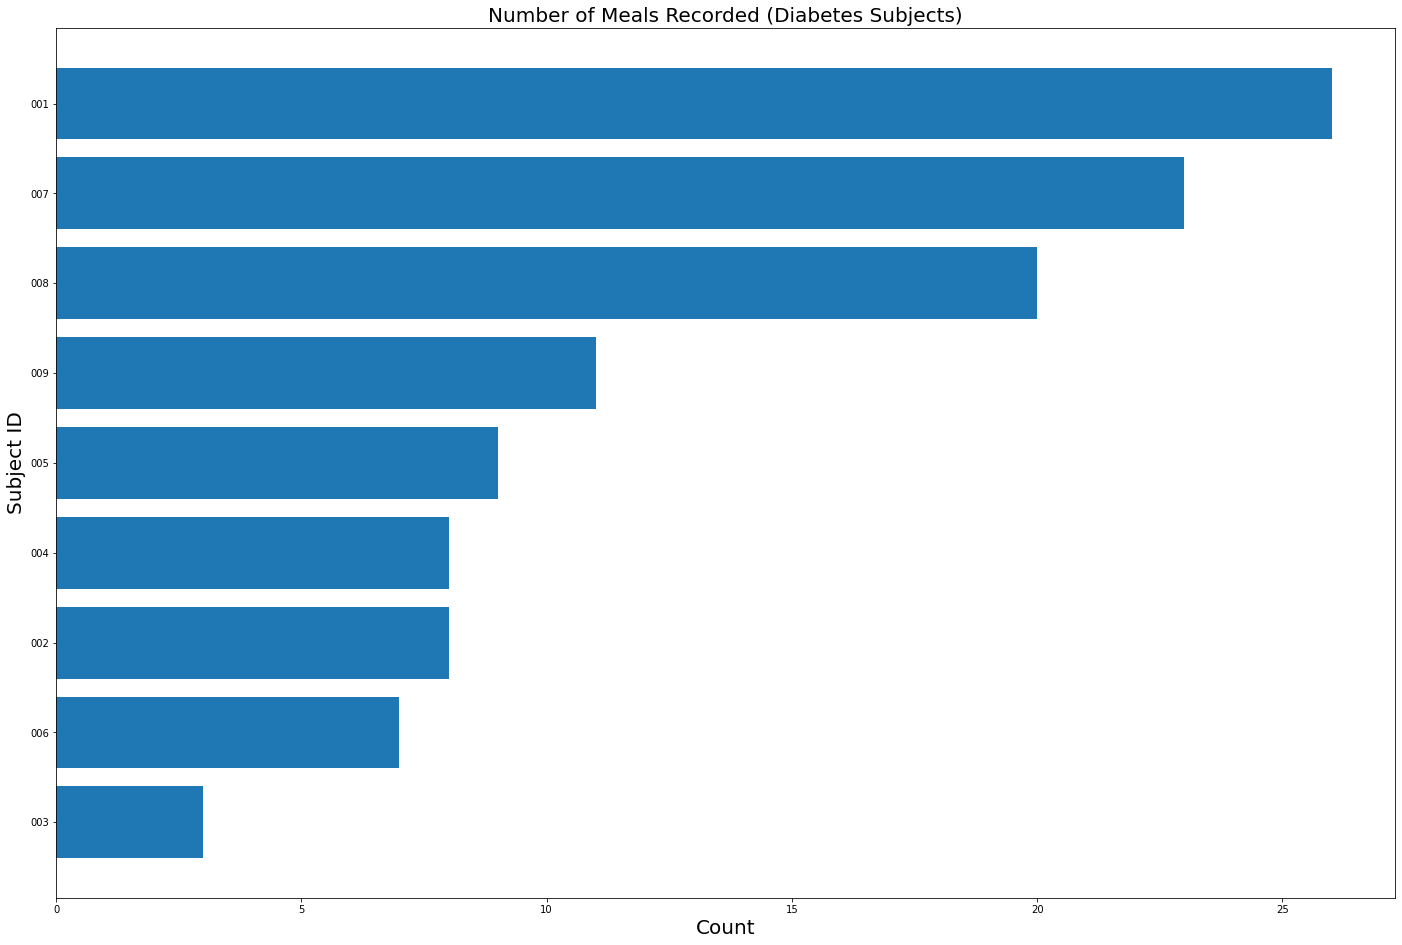

In [14]:
plot_subjects(diabetes_calories,"Len", "Number of Meals Recorded (Diabetes Subjects)", "Count")

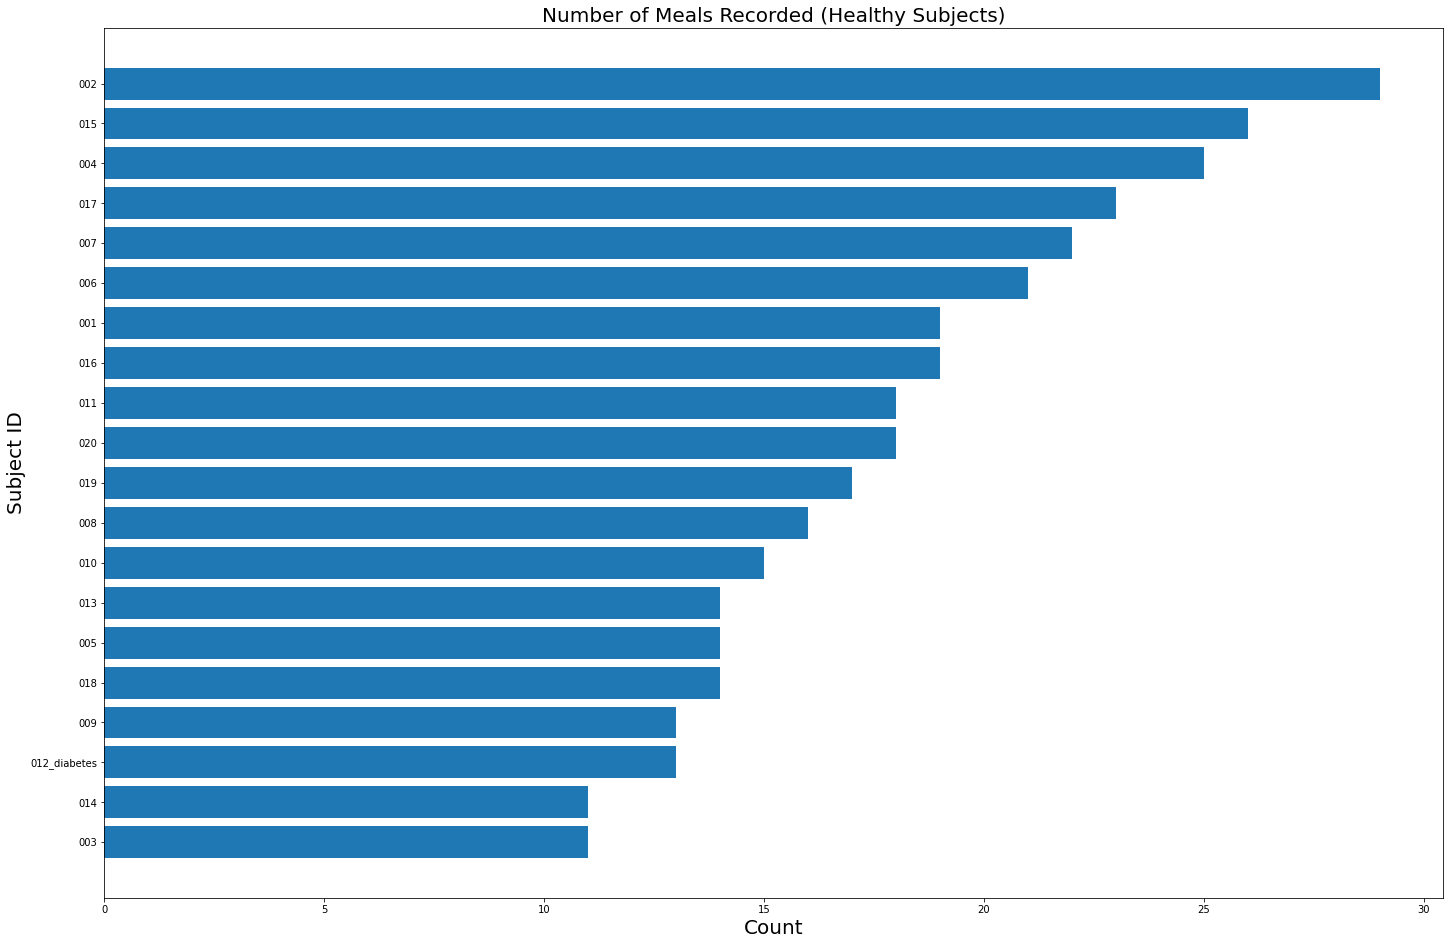

In [15]:
plot_subjects(healthy_calories,"Len", "Number of Meals Recorded (Healthy Subjects)", "Count")

#### Insights from the graphs

I can quickly see that some subjects were more thorough and inputed more data in comparison to others.  

Diabetes Subject 003 only included 3 meals over a 4 day period. While subject 001 included 25+ meals.  
For this reason I blieve that it will be difficult to use the food.csv file to complete further more complex analysis.



In [16]:
# I will collect glucose data from the glucose.csv file
glucose_levels = {}
glucose_data = {}
full_data = {}
for subject_type in os.listdir(top_path):
    glucose_levels[subject_type] = {}
    glucose_data[subject_type] = {}
    for subject_ID in os.listdir(top_path+subject_type):
        
        df = pd.read_csv("data/D1NAMO/"+subject_type+"/"+subject_ID+"/glucose.csv")
        process_glucose_file(df) # This function fixes some errors in the food.csv file.
        
        glucose_levels[subject_type][f"{subject_ID}"] = {
        "Mean": df["glucose"].mean(),
        "Count": df["glucose"].count() if subject_type == "healthy_subset" else df[df["type"] == "manual"]["glucose"].count(),
        "STD": np.std(df["glucose"])
                                                          }
        
        glucose_data[subject_type][f"{subject_ID}"] = df["glucose"]
        full_data[f"{subject_type[0]}_{subject_ID}"] = df["glucose"]

C:\Users\PC\AppData\Local\Temp/ipykernel_14440/3320481006.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["glucose"][i] = float(value)
C:\Users\PC\AppData\Local\Temp/ipykernel_14440/3320481006.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["glucose"][i] = float(value.replace(':', "."))


In [17]:
# Split the dict into two dataframes, sorted by the number of entries made.
diabetes_glucose_count = pd.DataFrame(glucose_levels["diabetes_subset"]).T.sort_values(by="Count")

healthy_glucose_count = pd.DataFrame(glucose_levels["healthy_subset"]).T.sort_values(by="Count")

Since the diabetes subject have a device that automatically takes their glucose level, I will only look at manual measurements

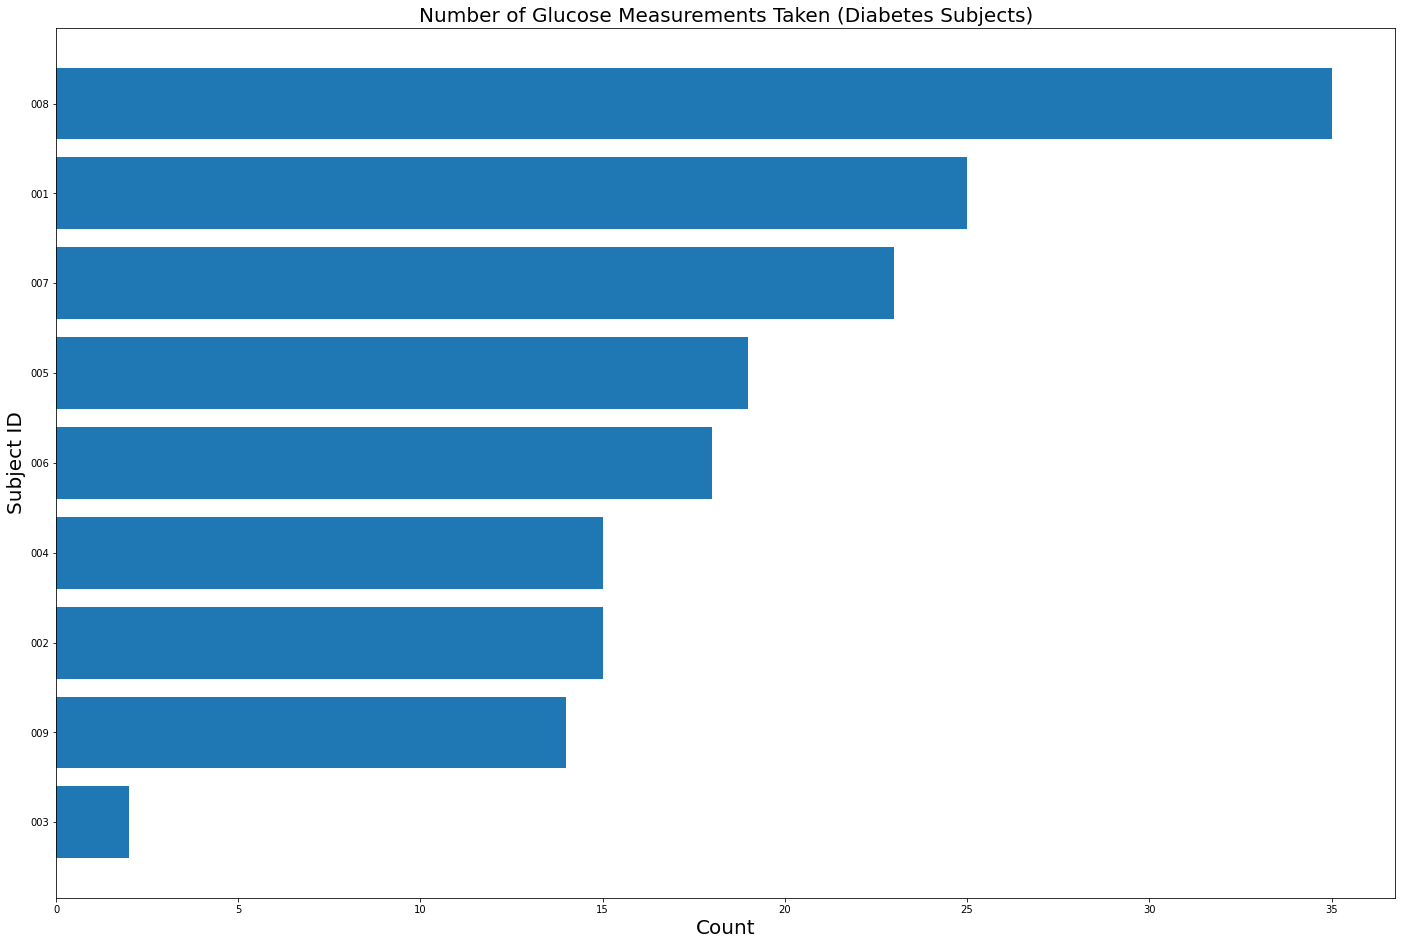

In [18]:
plot_subjects(diabetes_glucose_count,"Count", "Number of Glucose Measurements Taken (Diabetes Subjects)", "Count")

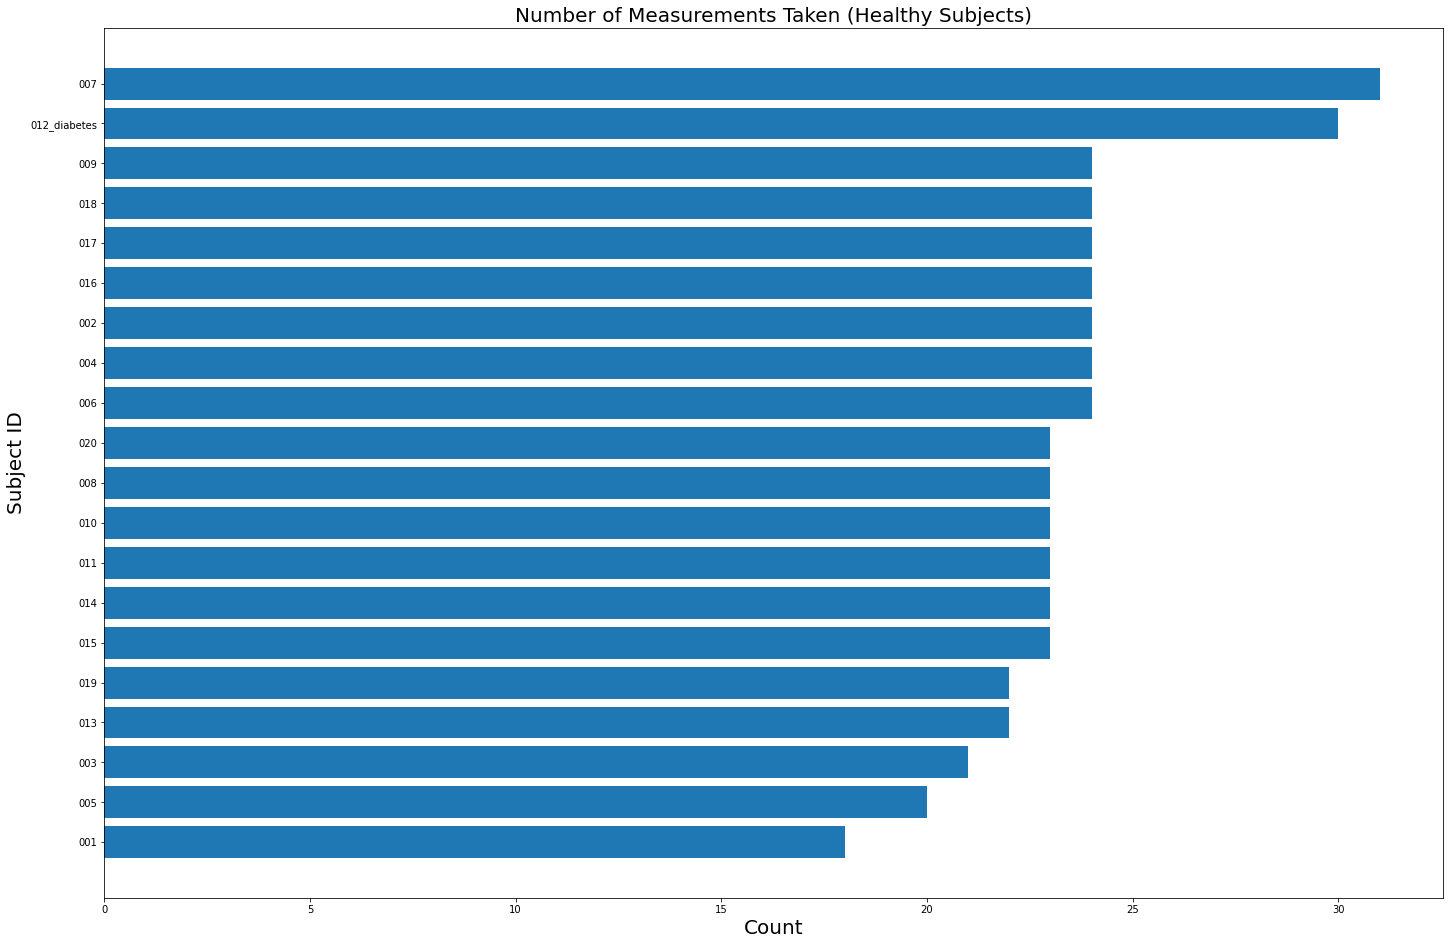

In [19]:
plot_subjects(healthy_glucose_count,"Count", "Number of Measurements Taken (Healthy Subjects)", "Count")

#### Insights

Once again it is clear that some subject (specifically the diabetes subset) were more thorough on thier data inputs than others.

I have come to the conclusion that I would like to create a model which classifies if a subject is diabetec or not...

I use different datasets to predicts:

1. Base Case: Glucose levels
2. Sensor data:





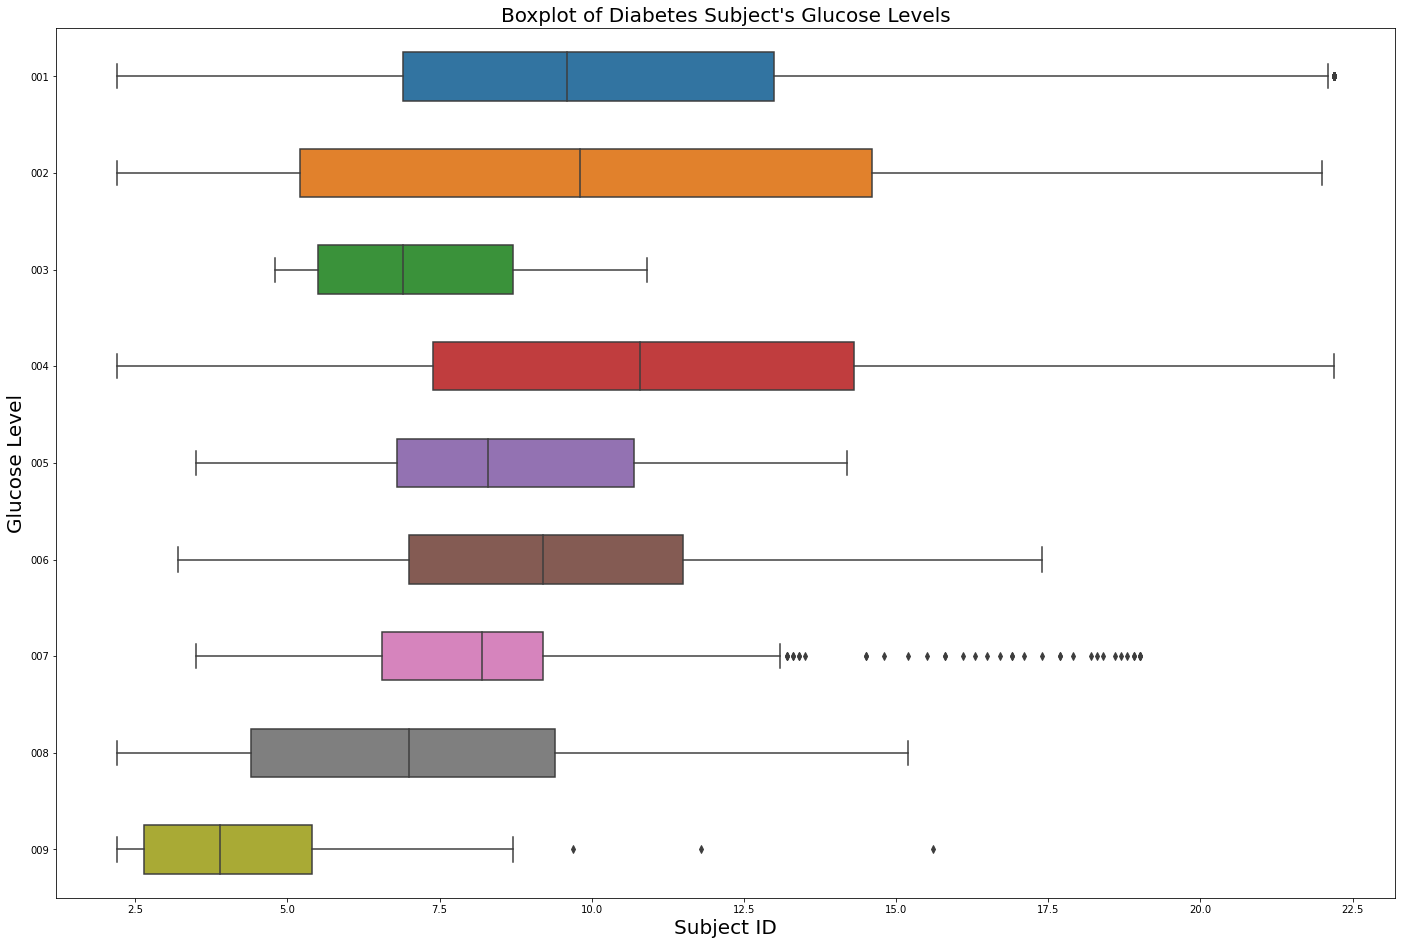

In [20]:
diabetes_glucose_data =  pd.DataFrame(glucose_data["diabetes_subset"])
plot_boxplot(diabetes_glucose_data, "Boxplot of Diabetes Subject's Glucose Levels")

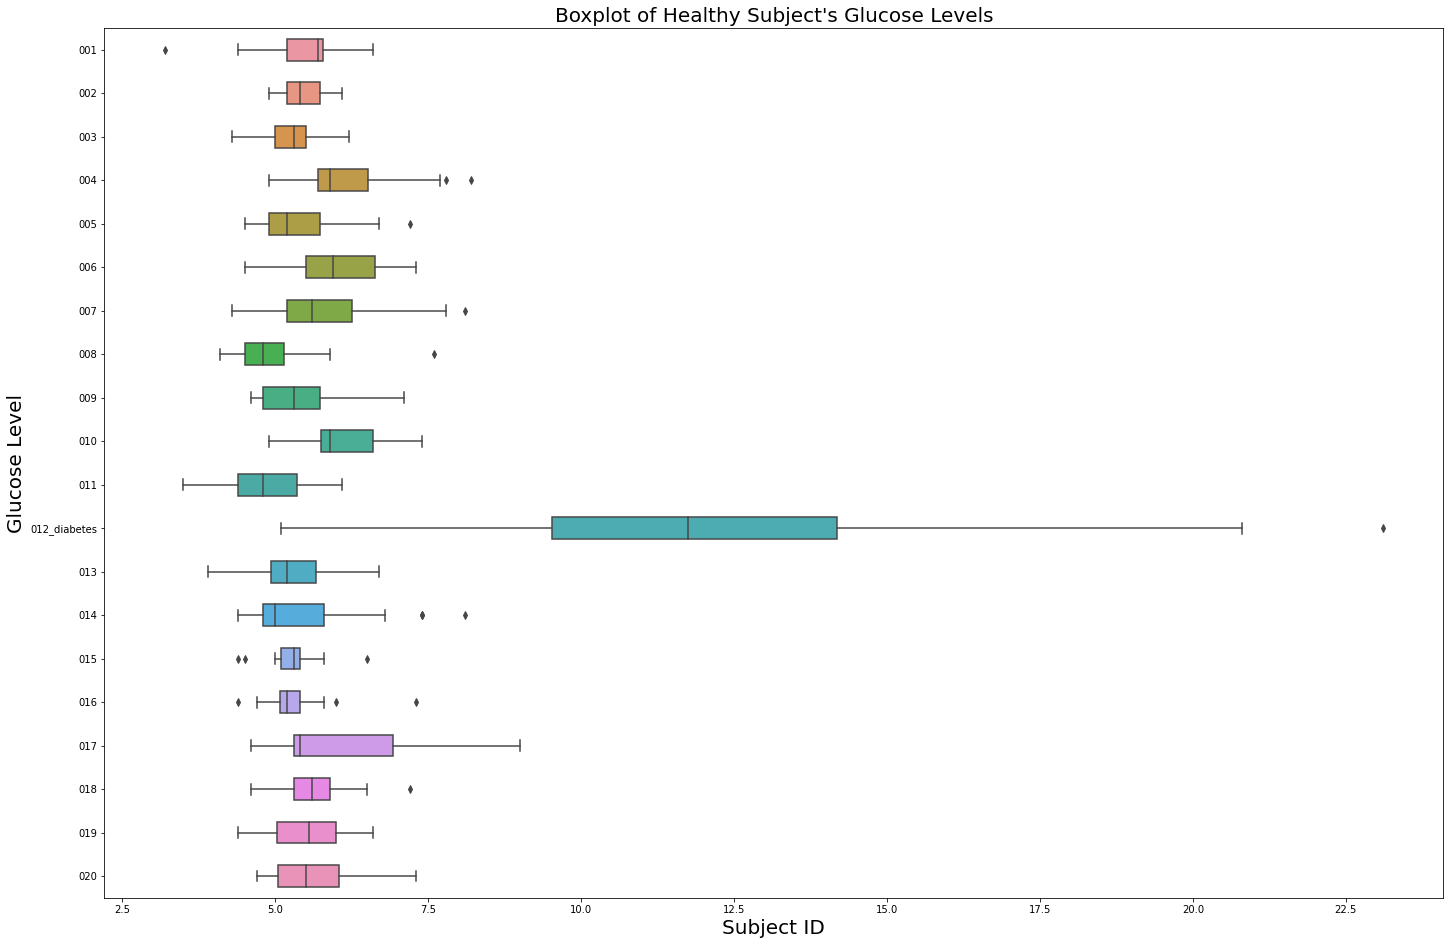

In [21]:
healthy_glucose_data =  pd.DataFrame(glucose_data["healthy_subset"])
plot_boxplot(healthy_glucose_data, "Boxplot of Healthy Subject's Glucose Levels")

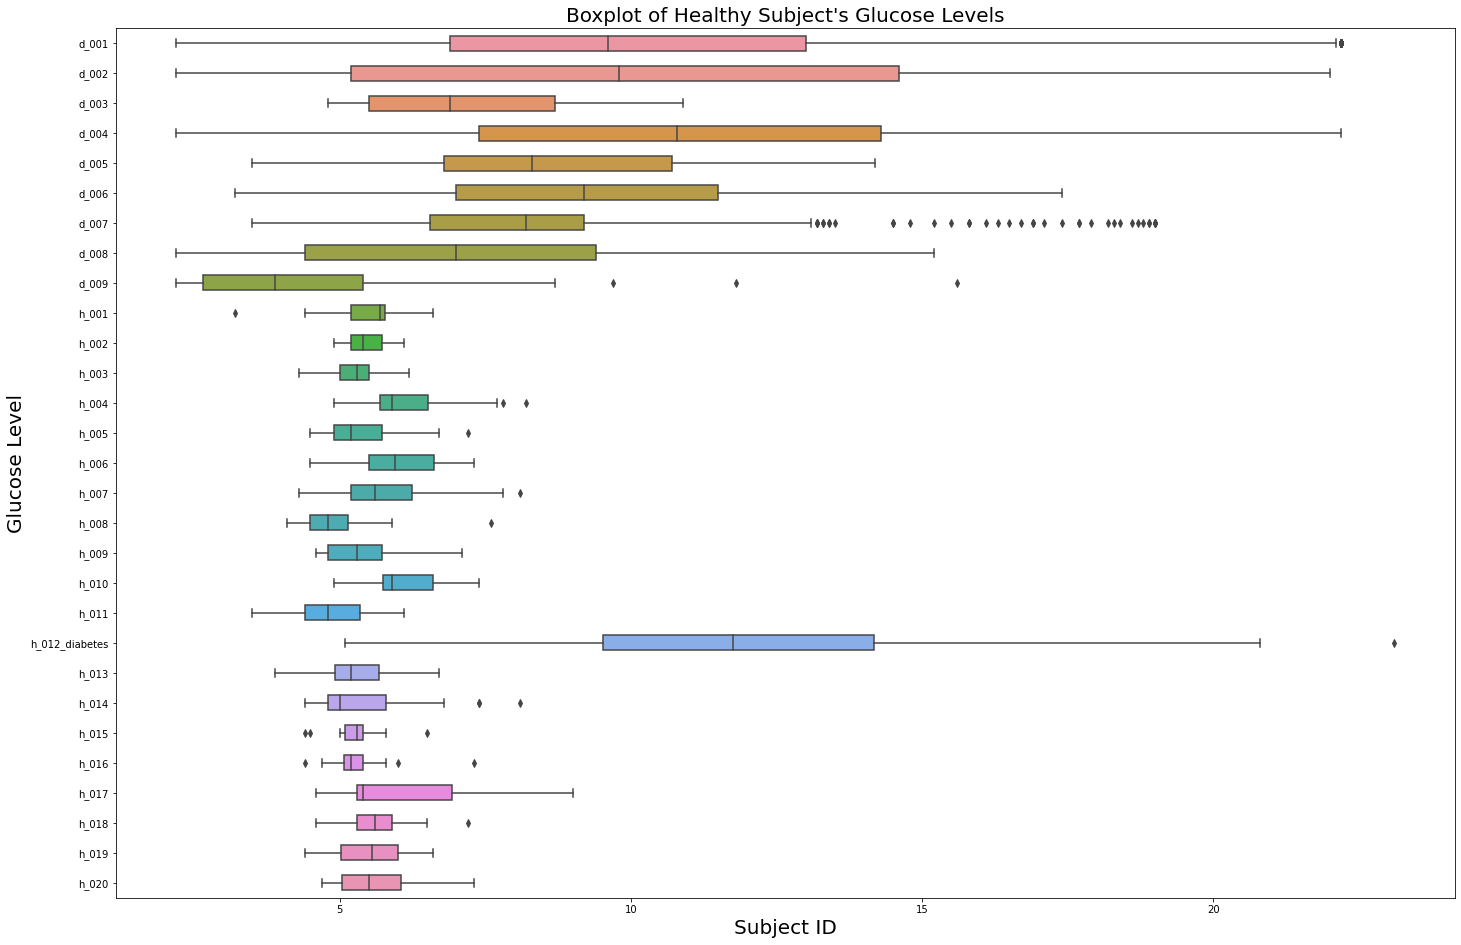

In [22]:
full_glucose_data =  pd.DataFrame(full_data)
plot_boxplot(full_glucose_data, "Boxplot of Healthy Subject's Glucose Levels")

In [23]:
full_glucose_data.describe()

,d_001,d_002,d_003,d_004,d_005,d_006,d_007,d_008,d_009,h_001,...,h_010,h_011,h_012_diabetes,h_013,h_014,h_015,h_016,h_018,h_019,h_020
count,1438.000000,1071.000000,185.000000,984.000000,928.000000,1298.000000,1011.000000,1175.000000,131.000000,18.000000,...,23.000000,23.000000,30.000000,22.000000,23.000000,23.000000,24.000000,24.000000,22.000000,23.000000
mean,10.194089,10.160224,7.126486,11.197053,8.553125,9.437057,8.287735,7.183489,4.337405,5.394444,...,6.113043,4.856522,12.310000,5.372727,5.465217,5.317391,5.300000,5.633333,5.531818,5.626087
std,4.869156,5.557664,1.851351,4.984142,2.491290,3.193368,2.498861,3.192047,2.049665,0.734424,...,0.604757,0.696632,4.397519,0.702500,1.041681,0.430277,0.568751,0.573825,0.661446,0.729394
min,2.200000,2.200000,4.800000,2.200000,3.500000,3.200000,3.500000,2.200000,2.200000,3.200000,...,4.900000,3.500000,5.100000,3.900000,4.400000,4.400000,4.400000,4.600000,4.400000,4.700000
25%,6.900000,5.200000,5.500000,7.400000,6.800000,7.000000,6.550000,4.400000,2.650000,5.200000,...,5.750000,4.400000,9.525000,4.925000,4.800000,5.100000,5.075000,5.300000,5.025000,5.050000
50%,9.600000,9.800000,6.900000,10.800000,8.300000,9.200000,8.200000,7.000000,3.900000,5.700000,...,5.900000,4.800000,11.750000,5.200000,5.000000,5.300000,5.200000,5.600000,5.550000,5.500000
75%,13.000000,14.600000,8.700000,14.300000,10.700000,11.500000,9.200000,9.400000,5.400000,5.775000,...,6.600000,5.350000,14.175000,5.675000,5.800000,5.400000,5.400000,5.900000,6.000000,6.050000
max,22.200000,22.000000,10.900000,22.200000,14.200000,17.400000,19.000000,15.200000,15.600000,6.600000,...,7.400000,6.100000,23.100000,6.700000,8.100000,6.500000,7.300000,7.200000,6.600000,7.300000


In [24]:
diabetes_five_top_picks = pick_top_subjects(diabetes_calories, diabetes_glucose_count, 5)

In [25]:
healthy_five_top_picks = pick_top_subjects(healthy_calories, healthy_glucose_count, 5)

In [26]:
for subject_type in os.listdir(top_path):
        try:
            os.mkdir(output_path+subject_type)
        except:
            pass
        for subject_ID in os.listdir(top_path+subject_type):
            try:
                os.mkdir("data/processed_data/"+subject_type+"/"+subject_ID)
            except:
                pass
            for filename in os.listdir(top_path+subject_type+"/"+subject_ID):
                try:
                    if len(filename.split(".")) == 1: 
                        os.mkdir("data/processed_data/"+subject_type+"/"+subject_ID+"/"+filename)
                except:
                    pass

In [27]:
copy_files(diabetes_five_top_picks, healthy_five_top_picks)

No such file or directory: data/D1NAMO/healthy_subset/007/sensor_data/2014_10_01-07_50_37/2014_10_01-07_50_37_Summary.csv
